# Import packages and initialization

In [1]:
from __future__ import print_function, division
import os
from collections import OrderedDict
import logging
from functools import partial

import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# Make the plots look pretty
matplotlib.rc('font',size=13)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')
# Use the same color cylcer as Seaborn
from cycler import cycler
color_cycle = [u'#4c72b0', u'#55a868', u'#c44e52', u'#8172b2', u'#ccb974', u'#64b5cd']
matplotlib.rcParams['axes.prop_cycle'] = cycler("color", color_cycle)

import lsst.afw.table as afwTable
from lsst.utils import getPackageDir
import lsst.log as log
import lsst.meas.deblender
from lsst.meas.deblender import proximal, display, sim, baseline
import lsst.meas.deblender.utils as debUtils

import deblender
import proxmin

logger = logging.getLogger("lsst.meas.deblender")
logger.setLevel(logging.INFO)
log.setLevel("", log.INFO)

plogger = logging.getLogger("proxmin")
plogger.setLevel(logging.INFO)

dlogger = logging.getLogger("deblender")
dlogger.setLevel(logging.INFO)

# Load and display the data

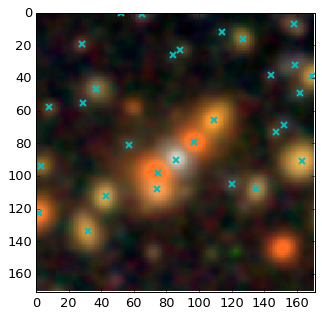

In [8]:
from astropy.table import Table
from astropy.io import fits

filters = ["g", "r", "i", "z"]

dataPath = os.path.abspath(os.path.join(lsst.utils.getPackageDir("testdata_deblender"),
                                        'real_data', 'cosmos_examples'))

peakTable = Table.read(os.path.join(dataPath, "example_26_cat.fits"))
imageList = []
for f in filters:
    img = fits.open(os.path.join(dataPath, "example_26_{0}.fits".format(f)))[0].data
    imageList.append(img)
images = np.array([i.tolist() for i in imageList])
peaks = [(peak["x"], peak["y"]) for peak in peakTable]
plt.figure(figsize=(7,7))
#img = display.imagesToRgb(images, contrast=10)
#plt.imshow(img)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
display.plotColorImage(images, ax=ax, show=False)
ax.plot(peakTable["x"], peakTable["y"], "cx", mew=2)
ax.set_xlim([0,images.shape[2]])
ax.set_ylim([images.shape[1], 0])
plt.show()

# Calculate the color of each pixels
(colors)

In [3]:
img_plus = images.copy()
img_plus[img_plus<0] = 0
norm = np.sum(img_plus, axis=0)
bad_idx = norm==0
norm[bad_idx] = 1
colors = images/norm

# Mask out the background and look at the color variations

The background is masked out by eliminating pixels with flux in at least two bands below zero.
This does a reasonable job leaving only the regions with flux from a source in them (plot 1),
and we see that around each source the SED doesn't differ by more than 0.1.

Notice that it also isolates sources that were not detected and might be useful as a multi-band source detection algorithm, which currently we aren't utilizing.

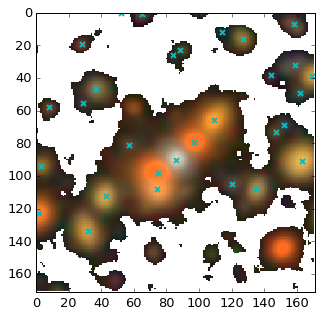

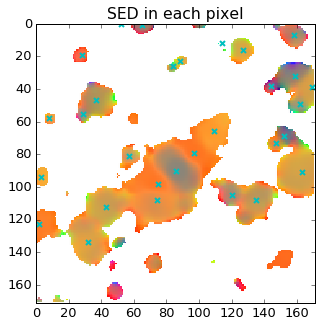

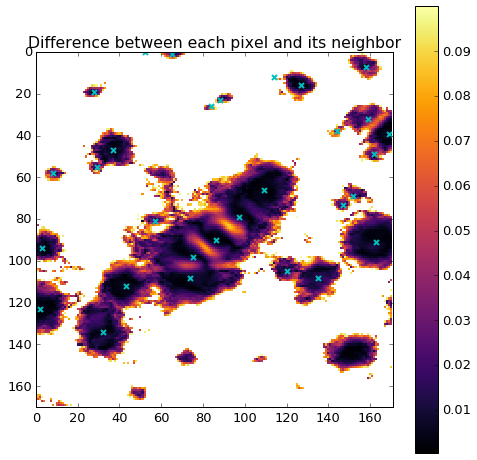

In [63]:
bkg_mask = np.sum(images<0, axis=0)>2
display.plotColorImage(images, show=False)
plt.imshow(np.ma.array(np.ones_like(bkg_mask), mask=~bkg_mask), cmap="Greys")
for px,py in peaks:
    plt.plot(px, py, "cx", mew=2, ms=5)
plt.xlim([0,bkg_mask.shape[1]])
plt.ylim([bkg_mask.shape[0],0])
plt.show()

cdiff = np.sum(np.abs(colors[:,1:,:]-colors[:,:-1,:]), axis=0)
bad = bkg_mask[:-1,:]|bkg_mask[1:,:]
bad = (cdiff>.1)|bad
cdiff = np.ma.array(cdiff, mask=bad)

tmp_mask = np.sum(images<0, axis=0)>0
c = colors.copy()
c[c<0] = 0
plotColorImage(c, show=False, vmin=0, vmax=.5, Q=1)
plt.imshow(np.ma.array(np.ones_like(tmp_mask), mask=~tmp_mask), cmap="Greys")
plt.title("SED in each pixel")
for px,py in peaks:
    plt.plot(px, py, "cx", mew=2, ms=5)
plt.xlim([0,bkg_mask.shape[1]])
plt.ylim([bkg_mask.shape[0],0])
plt.show()

plt.figure(figsize=(8,8))
plt.imshow(cdiff)
plt.colorbar()
plt.title("Difference between each pixel and its neighbor")
for px,py in peaks:
    plt.plot(px, py, "cx", mew=2, ms=5)
plt.xlim([0,cdiff.shape[1]])
plt.ylim([cdiff.shape[0],0])
plt.show()

# Select the bounding box for each source

This is just a first estimate at how this might work.
The basic idea is that when we look at an image, we know about how large an object is,
even if it's blended, because we look at the color of an object and find other pixels
that seem to be the same color.
The previous plot shows that the color of an object changes very little from pixel to pixel,
so we take advantage of that by looking for all pixels with a similar color.
We then mask out all of the pixels not connected to the peak in some way
(in other words, we eliminate other objects not blended with the current object that
have nearly the same color) and allow the bounding box of this new region to grow.
Doing so seems to do a good job enclosing each object, but this is just a first attempt
and can likely be improved (both in speed and methodology).

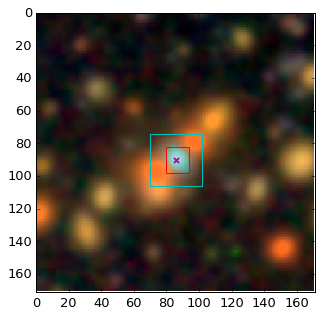

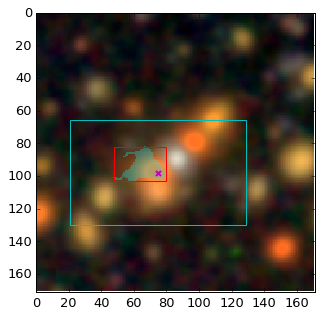

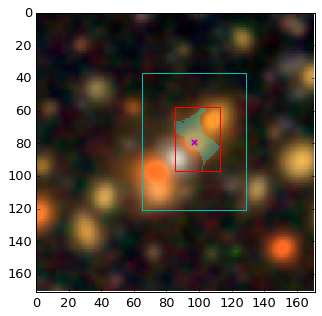

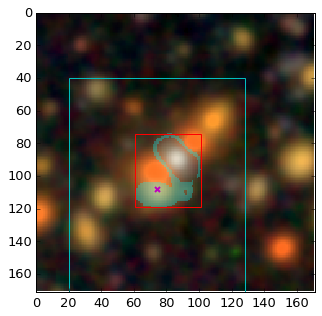

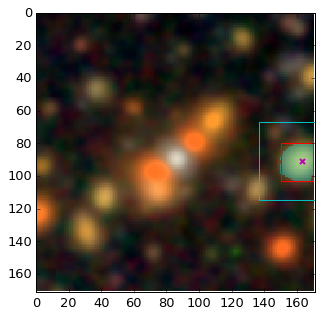

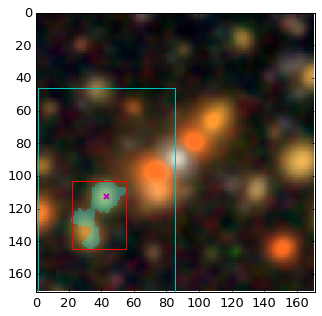

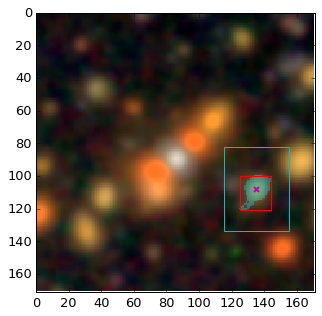

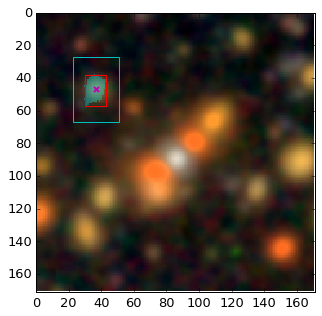

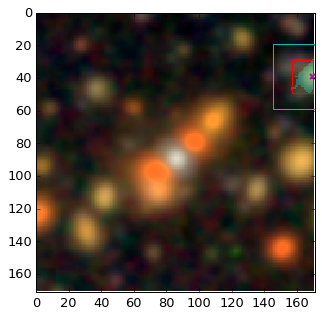

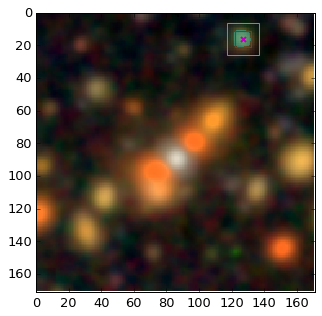

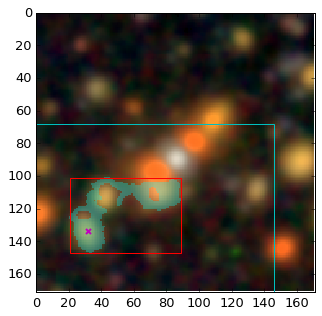

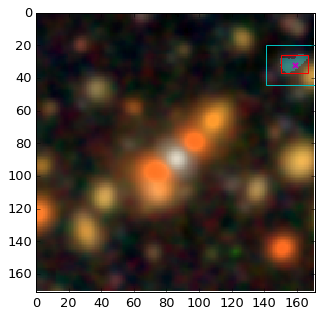

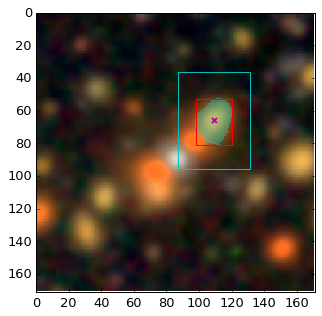

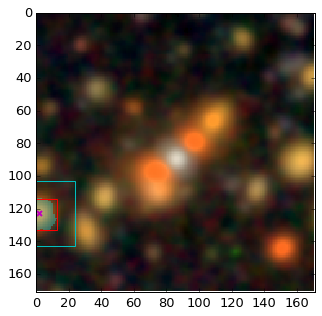

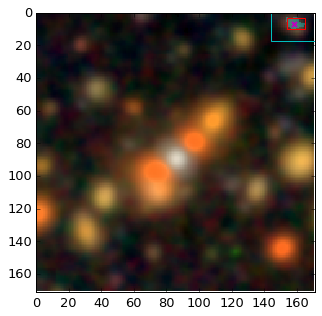

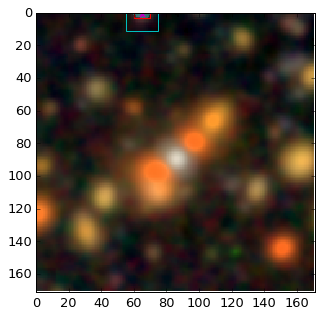

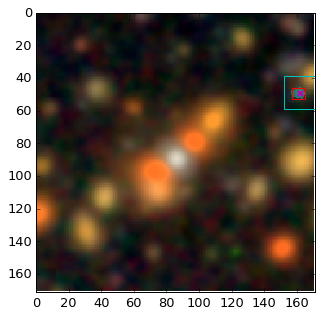

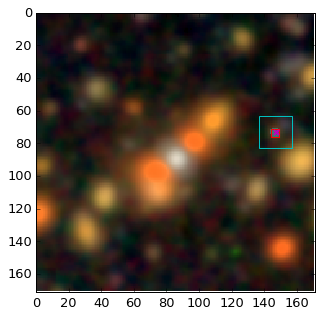

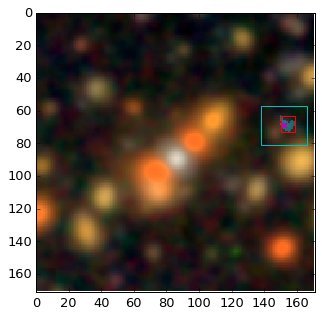

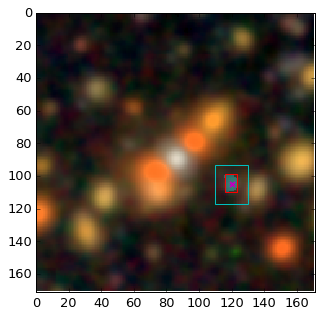

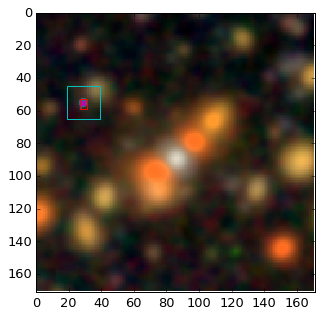

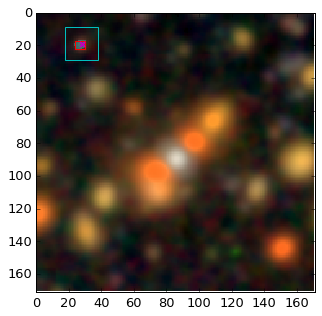

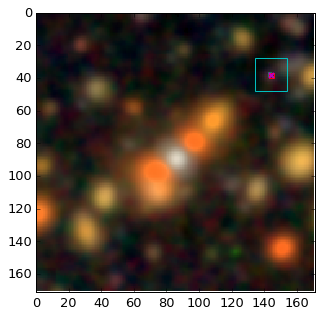

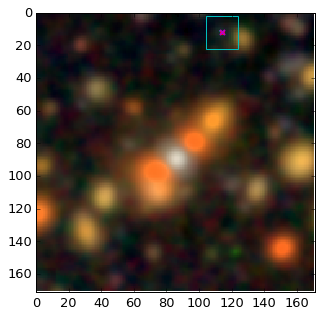

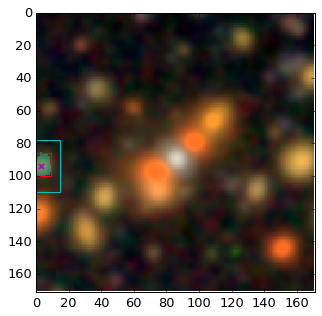

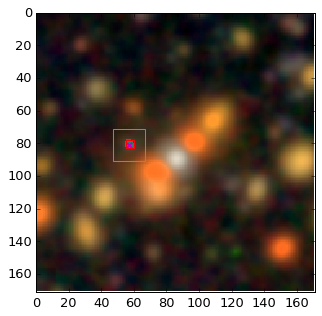

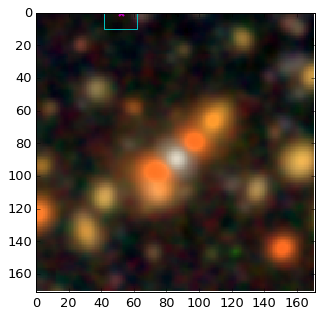

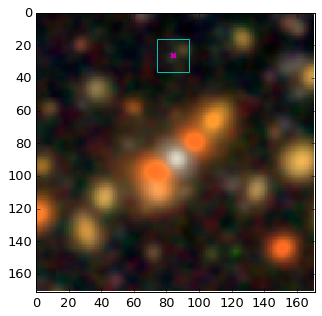

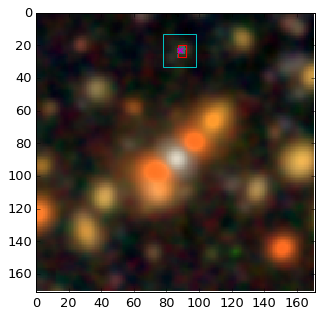

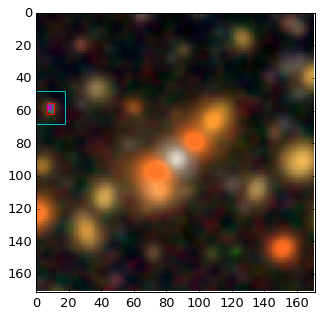

In [78]:
def get_connected(px, py, mask, connected=None, bounds=None):
    if connected is None:
        connected = np.zeros_like(mask, dtype=bool)
        bounds = [[px,py],[px,py]]
    else:
        if px<bounds[0][0]:
            bounds[0][0] = px
        elif px>bounds[1][0]:
            bounds[1][0] = px
        if py<bounds[0][1]:
            bounds[0][1] = py
        elif py>bounds[1][1]:
            bounds[1][1] = py
    connected[py,px] = 1
    pixels = [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]
    for dy,dx in pixels:
        if py+dy>=0 and px+dx>=0 and py+dy<mask.shape[0] and px+dx<mask.shape[1]:
            if mask[py+dy,px+dx] and not connected[py+dy,px+dx]:
                c, b = get_connected(px+dx, py+dy, mask, connected, bounds)
                connected = connected | c
                #print(px,py,bounds,b)
                bounds[0][0] = min(bounds[0][0], b[0][0])
                bounds[0][1] = min(bounds[0][1], b[0][1])
                bounds[1][0] = max(bounds[1][0], b[1][0])
                bounds[1][1] = max(bounds[1][1], b[1][1])
    return connected, bounds

def get_mask(px, py, colors, scale=2, min_size=20):
    sed = colors[:,py,px]
    _sed = np.array([np.ones_like(colors[0])*s for s in sed])
    diff = np.sum(np.abs(colors-_sed), axis=0)
    mask = diff<.1
    mask, bounds = get_connected(px, py, mask)
    
    dx = max(px-bounds[0][0],bounds[1][0]-px)*scale
    dy = max(py-bounds[0][1], bounds[1][1]-py)*scale
    dx = max(dx, min_size/2)
    dy = max(dy, min_size/2)
    
    bbox = [[px-dx,py-dy],[px+dx,py+dy]]
    return mask, bbox, bounds


for px, py in peaks:
    mask, bbox, bounds = get_mask(int(px), int(py), colors)
    display.plotColorImage(images, show=False)
    plt.imshow(np.ma.array(np.ones_like(images[0]), mask=~mask), cmap="cool", alpha=.3)
    
    xy = bounds[0]
    width = bounds[1][0]-bounds[0][0]
    height = bounds[1][1]-bounds[0][1]
    bb = patches.Rectangle(xy, width, height, linewidth=1, edgecolor='r',facecolor='none')
    plt.gca().add_patch(bb)
    
    xy = bbox[0]
    width = bbox[1][0]-bbox[0][0]
    height = bbox[1][1]-bbox[0][1]
    bb = patches.Rectangle(xy, width, height, linewidth=1, edgecolor='c',facecolor='none')
    plt.gca().add_patch(bb)
    
    plt.plot(px,py, "mx", mew=2, ms=5)
    plt.xlim([0,mask.shape[1]])
    plt.ylim([mask.shape[0],0])
    plt.show()